# Importing Libraries

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import cv2
from numpy.fft import fft2, fftshift, ifft2,ifftshift
from scipy import signal

# Reading Image

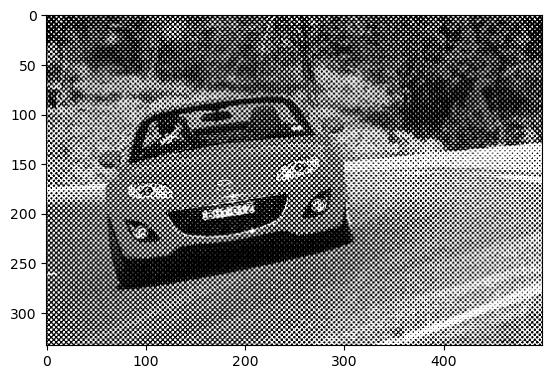

In [38]:
image = cv2.imread('car.png',cv2.IMREAD_GRAYSCALE)
image= cv2.resize(image,(500,333))
imshow(image,cmap='gray')

# Calculating the Discrete Fourier transform of the car image. 

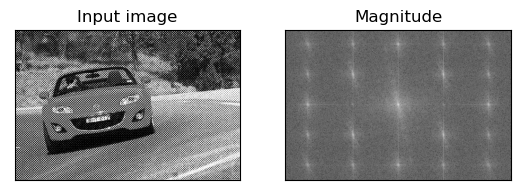

In [39]:
#apply 2d DFT
f=np.fft.fft2(image)

#shift to center
fshift=np.fft.fftshift(f)

#magnitude
magnitude_spectrum=20*np.log(np.abs(fshift))

#visualizing
plt.subplot(121), plt.imshow(image, cmap='gray')
plt.title('Input image'), plt.xticks([]),plt.yticks([])
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude'), plt.xticks([]),plt.yticks([])
plt.show()

# Notice that white peaks in the Fourier domain capture periodic noise present in the original image.
To remove the periodic noise, we used the "peak_local_max" function to find the coordinates of the local maxima, in the log-transformed magnitude of the Fourier transform.

In [40]:
from skimage.feature import peak_local_max
coordinates = peak_local_max(magnitude_spectrum, min_distance= 6, exclude_border=0)

coordinates

array([[166, 250],
       [233, 350],
       [ 99, 150],
       ...,
       [332,  85],
       [  8, 412],
       [324,  88]])

## You want to clean the original image in the Fourier domain such that its magnitude only has a single bright "star" in the center. Given below is a script that helps you experiment with the width of the filter (2L+1 x 2L+1) that covers frequency components of the periodic noise that we want to remove.

Text(0.5, 1.0, 'The size of the neighbourhood is 7x7')

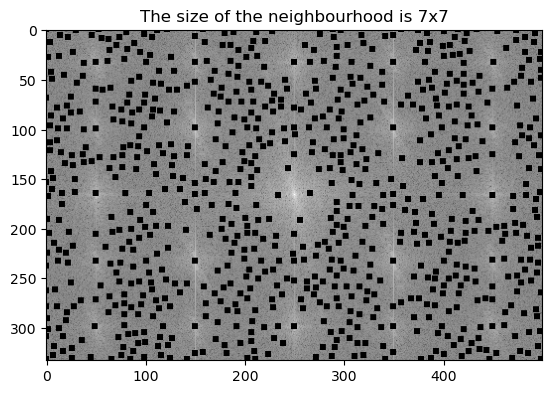

In [41]:
#clean the image to get single star in the center
L = 3
dx,dy=np.shape(image)[0], np.shape(image)[1]
new= magnitude_spectrum.copy()

for coord in coordinates:
    i=coord[0]
    j=coord[1]
    if i==dx//2 and j==dy//2:
        continue
    else:    
        for k1 in np.arange(-L,L,1):
            for k2 in np.arange(-L,L,1):
                if i+k1>=0 and j+k2>=0 and i+k1<dx and j+k2<dy:
                    new[i+k1,j+k2]=0
                    fshift[i+k1,j+k2]=0 # shifted DFT of car image 
imshow(new, cmap='gray')
plt.title("The size of the neighbourhood is "+str(2*L+1)+"x"+str(2*L+1))

# L = 3 gave the best value overall

# Perform the inverse Fourier transform (using modified frequency components) to get the image back. Visualize your result.

Text(0.5, 1.0, 'Filtered Image')

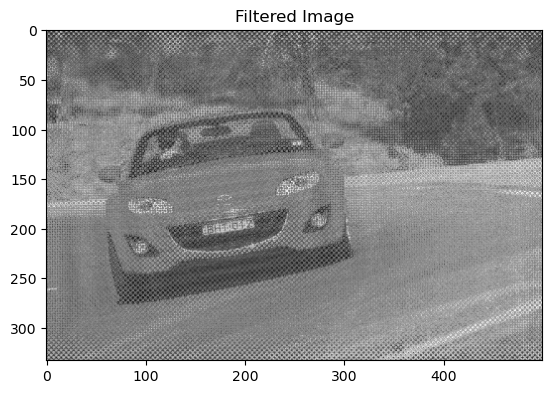

In [42]:
# Perform inverse Fourier transform to obtain the filtered image
filtered_image = np.fft.ifftshift(fshift)
filtered_image = ifft2(filtered_image)

# Take the real part of the filtered image (imaginary part is negligible)
filtered_image = np.real(filtered_image)

image_back= (filtered_image-np.min(filtered_image))*255.0/(np.max(filtered_image)-np.min(filtered_image)) 
# Visualize the filtered image
plt.imshow(image_back, cmap='gray')
plt.title('Filtered Image')

# Slice image to get only number plate region.

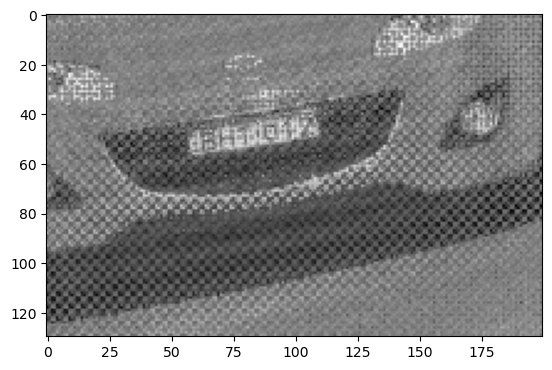

In [43]:
import skimage
from skimage import transform
#scaled= transform.rescale(image_back,1.2, anti_aliasing=False)
image_back = image_back[150:280,100:300]
plt.imshow(image_back,cmap='gray')

# Apply gaussian filter

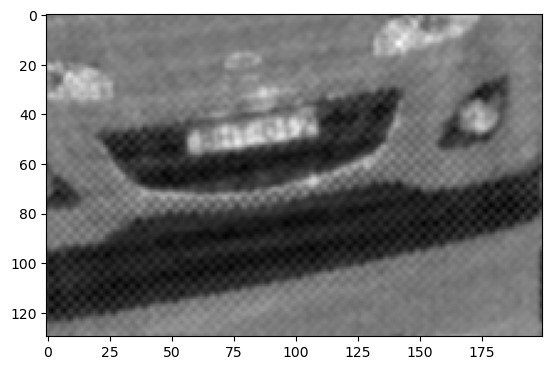

In [45]:
from scipy import signal

# create a low-pass Gaussian filter
kernel = np.outer(signal.gaussian(image_back.shape[0], 1), signal.gaussian(image_back.shape[1], 1))
# find Fourier transform of the image f(x,y)
freq = fft2(image_back)
# generate a kernel whose origin is in the top-left corner
kern = ifftshift(kernel)  # h(x,y)
# calculate FFT of the kernel
freq_kernel = fft2(kern)
# multiply in the frequency domain
low_pass_product = freq * freq_kernel
# compute the low-pass filtered image
low_pass_im = ifft2(low_pass_product).real

plt.imshow(low_pass_im, cmap='gray')

# Apply gamma correction to improve contrast.

(array([2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 7.000e+00,
        7.000e+00, 1.300e+01, 2.000e+01, 3.900e+01, 3.600e+01, 6.700e+01,
        1.130e+02, 1.790e+02, 2.760e+02, 3.370e+02, 4.330e+02, 7.290e+02,
        1.084e+03, 1.417e+03, 1.844e+03, 2.280e+03, 3.094e+03, 5.152e+03,
        5.234e+03, 2.357e+03, 6.870e+02, 3.660e+02, 1.950e+02, 2.700e+01]),
 array([3.29793584, 3.45245768, 3.60697952, 3.76150136, 3.9160232 ,
        4.07054504, 4.22506688, 4.37958872, 4.53411056, 4.6886324 ,
        4.84315424, 4.99767608, 5.15219792, 5.30671976, 5.4612416 ,
        5.61576344, 5.77028528, 5.92480712, 6.07932896, 6.2338508 ,
        6.38837264, 6.54289448, 6.69741632, 6.85193816, 7.00646   ,
        7.16098184, 7.31550368, 7.47002552, 7.62454736, 7.7790692 ,
        7.93359104]),
 [<matplotlib.patches.Polygon at 0x7f8400059640>])

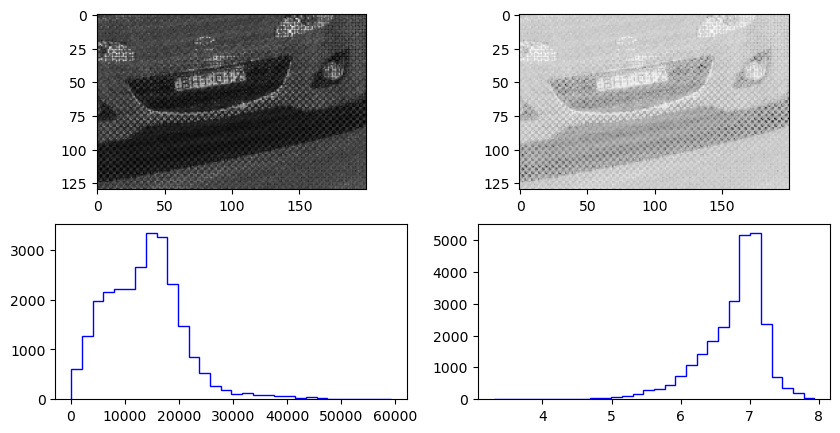

In [46]:
from skimage import exposure,img_as_float

fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
# Gamma corrected
gamma_corrected = exposure.adjust_gamma(image_back, 2)

# logarithmic corrected
logarithmic_corrected = exposure.adjust_log(image_back, 1)

ax[0,0].imshow(gamma_corrected,cmap='gray')
ax[0,1].imshow(logarithmic_corrected,cmap='gray')
ax[1,0].hist(gamma_corrected.ravel(), bins=30, histtype='step', color='b' )
ax[1,1].hist(logarithmic_corrected.ravel(), bins=30, histtype='step', color='b' )

## Choose a midpoint around which you want to stretch contrast and normalize the previous output

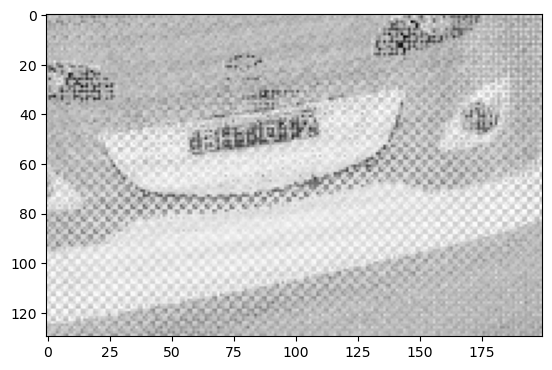

In [47]:
def normalize(intensity, m, E):
    I = intensity
    dx, dy = np.shape(intensity)[0], np.shape(intensity)[1]
    eps = 0.001
    cs = np.zeros((dx, dy))
    for i in range(dx):
        for j in range(dy):
            cs[i, j] = (I[i, j] - m) * (E / (1 - m - eps))
    return cs

# choose a midpoint of 128 and maximum intensity value of 255
m = 100
E = 200

# apply contrast stretching to the Fourier-reconstructed image
g = normalize(gamma_corrected, m, E)

# display the resulting image
plt.imshow(g, cmap='gray')